## <u>*Calssifications Modelling for number of claims as a Target Feature*</u>

In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [2]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )


from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,XGBRFClassifier
import warnings
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,BaggingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
   

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Classification Models to use :*</u>

In [4]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "GradientBoostingClassifier": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "CatBoostClassifier": CatBoostClassifier(verbose=False),
                "AdaBoostClassifier": AdaBoostClassifier(),
                "BaggingClassifier":BaggingClassifier()
            }

#### *A.2. <br> <u>Classification Models spaces preperartion to use in hyperopt :*</u>

In [5]:
space_xgboost_clf  = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

space_rf_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}


space_GradientBoosting_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
}

space_DT = {
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('depth', range(1, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}



space_Bagging_clf = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
}

space_catboost_clf = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'iterations': hp.quniform('iterations', 50, 200, 1),
    'depth': hp.choice('depth', range(1, 15)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}

---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>Solving imbalanced issue if exist :*</u>

In [6]:
print(df5.groupby("numclaims")["numclaims"].count())
print(df5.groupby("numclaims")["numclaims"].count()/df5["numclaims"].count())

numclaims
0    63232
1     4333
2      271
3       18
4        2
Name: numclaims, dtype: int64
numclaims
0    0.931856
1    0.063856
2    0.003994
3    0.000265
4    0.000029
Name: numclaims, dtype: float64


> *The data balnance between between numclaims are vary*

In [7]:
df5=df5[df5["numclaims"]!=4]

#### *B.2. <br> <u>LabelEncoding for categorical features :*</u>

In [8]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.3. <br> <u>Define x & y features :*</u>

In [9]:
x=df5.drop("numclaims",axis=1)
y=df5["numclaims"]

#### *B.4. <br> <u>apply data balance method :*</u>

In [10]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)

#### *B.5. <br> <u>data splitting (training & testing) :*</u>

In [11]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBClassifier:*</u>

In [12]:
def model_XGBClassifier(space_xgboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(space_xgboost_clf['learning_rate']),
               n_estimators=int(space_xgboost_clf['n_estimators']),
               max_depth=int(space_xgboost_clf['max_depth']),
               min_child_weight=int(space_xgboost_clf['min_child_weight']),
               subsample=float(space_xgboost_clf["subsample"]),
               gamma=float(space_xgboost_clf['gamma']),
               colsample_bytree=float(space_xgboost_clf['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [13]:
def model_XGBClassifier_best(best_model_XGBClassifier):
    y_model_XGBClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_XGBClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_XGBClassifier_best Accuracy_result:',  np.mean(Accuracy_list))

In [14]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)
model_XGBClassifier_best(best_model_XGBClassifier)

100%|██████████| 10/10 [08:45<00:00, 52.56s/trial, best loss: 0.9945966604725945]
model_XGBClassifier_best Accuracy_result: 0.9746570197287787


#### *C.2 <br> <u>* *RandomForestClassifier:*</u>

In [46]:
def model_rf_clf(space_rf_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(space_rf_clf['n_estimators']),
                                    #criterion=int(space_rf_clf['criterion']),                                                       
                                    max_depth=int(space_rf_clf['max_depth']),
                                    min_samples_split=float(space_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(space_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(space_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [47]:
def model_rf_clf_best(best_model_rf_clf):
    y_model_rf_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
              ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(best_model_rf_clf['n_estimators']),
                                    #criterion=int(best_model_rf_clf['criterion']),                                                       
                                    max_depth=int(best_model_rf_clf['max_depth']),
                                    min_samples_split=float(best_model_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(best_model_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_rf_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_rf_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [48]:
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
model_rf_clf_best(best_model_rf_clf)

100%|██████████| 10/10 [01:52<00:00, 11.27s/trial, best loss: 0.24898852119822348]
model_rf_clf_best Accuracy_result: 0.5800814454592179


---

#### *C.3 <br> <u>* *GradientBoostingClassifier:*</u>

In [16]:
def model_GradientBoosting_clf(space_GradientBoosting_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(space_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(space_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(space_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(space_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(space_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(space_GradientBoosting_clf['subsample'])

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [17]:
def model_GradientBoosting_clf_best(best_model_GradientBoosting_clf):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(best_model_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(best_model_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(best_model_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(best_model_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(best_model_GradientBoosting_clf['subsample'])


                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_GradientBoosting_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [19]:
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)

100%|██████████| 10/10 [02:08<00:00, 12.81s/trial, best loss: 0.9310802181067938]
model_GradientBoosting_clf_best Accuracy_result: 0.9310802181067938


----

#### *C.4 <br> <u>* *DecisionTreeClassifier:*</u>

In [20]:
def model_DT(space_DT):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(space_DT['criterion']),                                                       
                                    splitter=str(space_DT['splitter']),
                                    max_depth=int(space_DT['max_depth']),
                                    min_samples_split=float(space_DT['min_samples_split']),
                                    min_samples_leaf=float(space_DT['min_samples_leaf']),
                                    #max_features=int(space_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 


In [21]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(best_model_DT['criterion']),                                                       
                                    #splitter=str(best_model_DT['splitter']),
                                    max_depth=int(best_model_DT['depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf']),
                                    #max_features=int(best_model_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_DT_best Accuracy_result:',  np.mean(Accuracy_list))

In [23]:
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 54.64trial/s, best loss: 0.9310802181067938]
model_DT_best Accuracy_result: 0.9310802181067938


---

#### *C.5 <br> <u>* *BaggingClassifier:*</u>

In [24]:
def model_Bagging(space_Bagging_clf):
    base_classifier =DecisionTreeClassifier()
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(space_Bagging_clf['n_estimators']),
                                    bootstrap=int(space_Bagging_clf["bootstrap"]),                                                       
                                    bootstrap_features=int(space_Bagging_clf['bootstrap_features']),
                                    max_samples=float(space_Bagging_clf["max_samples"]),
                                    max_features=float(space_Bagging_clf["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [25]:
def model_Bagging_best(best_model_BaggingClassifier):
    base_classifier =DecisionTreeClassifier()
    y_Bagging_best=[]
    Accuracy_list=[]

    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_Bagging_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_Bagging_best Accuracy_result:',  np.mean(Accuracy_list))

In [26]:
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
model_Bagging_best(best_model_BaggingClassifier)

100%|██████████| 10/10 [00:23<00:00,  2.30s/trial, best loss: 0.9310802181067938]
model_Bagging_best Accuracy_result: 0.9310802181067938


---

#### *C.6 <br> <u>* *CatBoostClassifier:*</u>

In [27]:
def model_catboost(space_catboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(space_catboost_clf['learning_rate']),
                                    depth=int(space_catboost_clf["depth"]),                                                       
                                    iterations=int(space_catboost_clf['iterations']),
                                    l2_leaf_reg=float(space_catboost_clf["l2_leaf_reg"]),
                                    border_count=int(space_catboost_clf["border_count"]),
                                    bagging_temperature=float(space_catboost_clf["bagging_temperature"]),
                                    random_strength=float(space_catboost_clf["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [28]:
def model_catboost_best(best_model_catboost):
    y_CatBoostClassifier_best=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_CatBoostClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    print('model_catboost_best Accuracy_result:', Accuracy_result)


In [29]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)
model_catboost_best(best_model_catboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 1.2967247	total: 171ms	remaining: 24.5s
1:	learn: 1.0887982	total: 198ms	remaining: 14.1s
2:	learn: 0.9344176	total: 228ms	remaining: 10.7s
3:	learn: 0.8134674	total: 256ms	remaining: 8.96s
4:	learn: 0.7150457	total: 283ms	remaining: 7.87s
5:	learn: 0.6331851	total: 312ms	remaining: 7.17s
6:	learn: 0.5640085	total: 342ms	remaining: 6.7s
7:	learn: 0.5045776	total: 376ms	remaining: 6.38s
8:	learn: 0.4532069	total: 406ms	remaining: 6.09s
9:	learn: 0.4082437	total: 437ms	remaining: 5.85s
10:	learn: 0.3687121	total: 463ms	remaining: 5.6s
11:	learn: 0.3337591	total: 491ms	remaining: 5.4s
12:	learn: 0.3027070	total: 519ms	remaining: 5.23s
13:	learn: 0.2749990	total: 546ms	remaining: 5.07s
14:	learn: 0.2502005	total: 576ms	remaining: 4.95s
15:	learn: 0.2279160	total: 605ms	remaining: 4.84s
16:	learn: 0.2078594	total: 635ms	remaining: 4.74s
17:	learn: 0.1897836	total: 662ms	remaining: 4.63s
18:	learn: 0.1734415	total: 689ms	remaini

7:	learn: 1.3618926	total: 90.3ms	remaining: 1.04s
8:	learn: 1.3360029	total: 107ms	remaining: 1.08s
9:	learn: 1.3110155	total: 125ms	remaining: 1.12s
10:	learn: 1.2868688	total: 142ms	remaining: 1.15s
11:	learn: 1.2635221	total: 154ms	remaining: 1.13s
12:	learn: 1.2409288	total: 347ms	remaining: 2.32s
13:	learn: 1.2190454	total: 461ms	remaining: 2.83s
14:	learn: 1.1978344	total: 570ms	remaining: 3.23s
15:	learn: 1.1772613	total: 652ms	remaining: 3.42s
16:	learn: 1.1572939	total: 724ms	remaining: 3.53s
17:	learn: 1.1379027	total: 743ms	remaining: 3.39s
18:	learn: 1.1190586	total: 763ms	remaining: 3.25s
19:	learn: 1.1007390	total: 787ms	remaining: 3.15s
20:	learn: 1.0829182	total: 820ms	remaining: 3.08s
21:	learn: 1.0655741	total: 841ms	remaining: 2.98s
22:	learn: 1.0486859	total: 860ms	remaining: 2.88s
23:	learn: 1.0322340	total: 878ms	remaining: 2.78s
24:	learn: 1.0161983	total: 895ms	remaining: 2.68s
25:	learn: 1.0005651	total: 913ms	remaining: 2.6s
26:	learn: 0.9853145	total: 930ms	

---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

> *XGBClassifier has the highest accuracy score*

In [15]:
y_model_XGBClassifier_best=[]
Accuracy_list=[]
XGBClassifier_model = XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree']))               

                                  
                                                                               
XGBClassifier_model.fit(xtrain,ytrain)
y_pred=XGBClassifier_model.predict(xtest)
Accuracy_result=accuracy_score(ytest,y_pred)

y_model_XGBClassifier_best.append(y_pred)

Accuracy_result=accuracy_score(ytest,y_pred)
Accuracy_list.append(Accuracy_result)
    

In [16]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18982
           1       1.00      0.95      0.97     18893
           2       0.96      0.95      0.95     19038
           3       0.95      1.00      0.97     18966

    accuracy                           0.97     75879
   macro avg       0.98      0.97      0.97     75879
weighted avg       0.98      0.97      0.97     75879



In [17]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, y_pred),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3
Actual0,18982,0,0,0
Actual1,0,17935,831,127
Actual2,0,47,18073,918
Actual3,0,0,0,18966


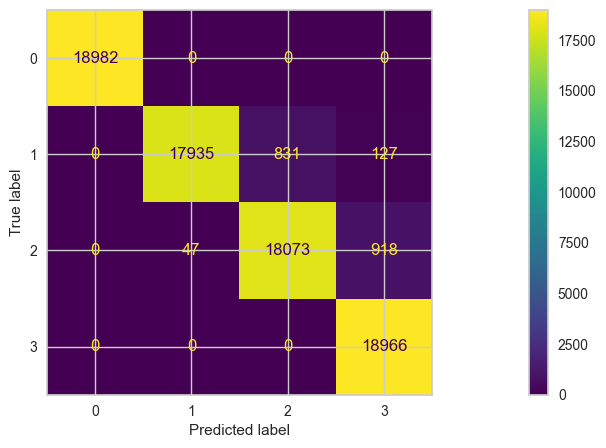

In [18]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(ytest,y_pred)).plot()

In [19]:
from sklearn.multiclass import OneVsRestClassifier

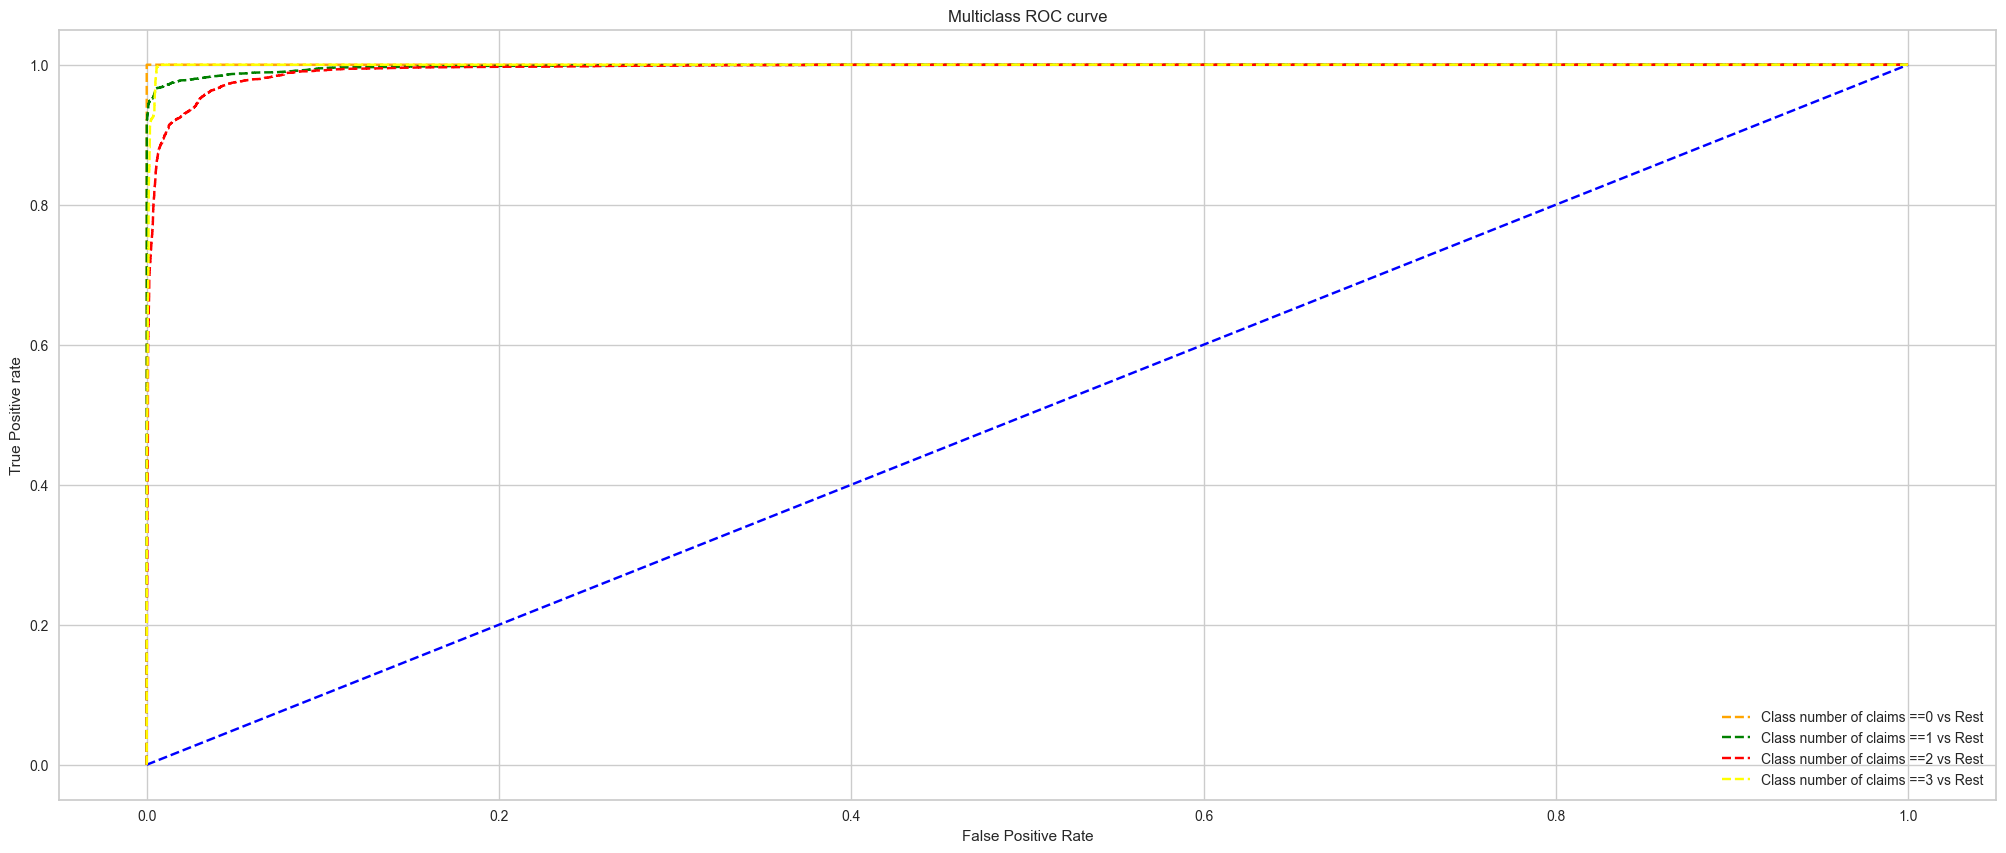

In [20]:
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier(XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])))


clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)
pred_prob = clf.predict_proba(xtest)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class number of claims ==0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class number of claims ==1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class number of claims ==2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class number of claims ==3 vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);    


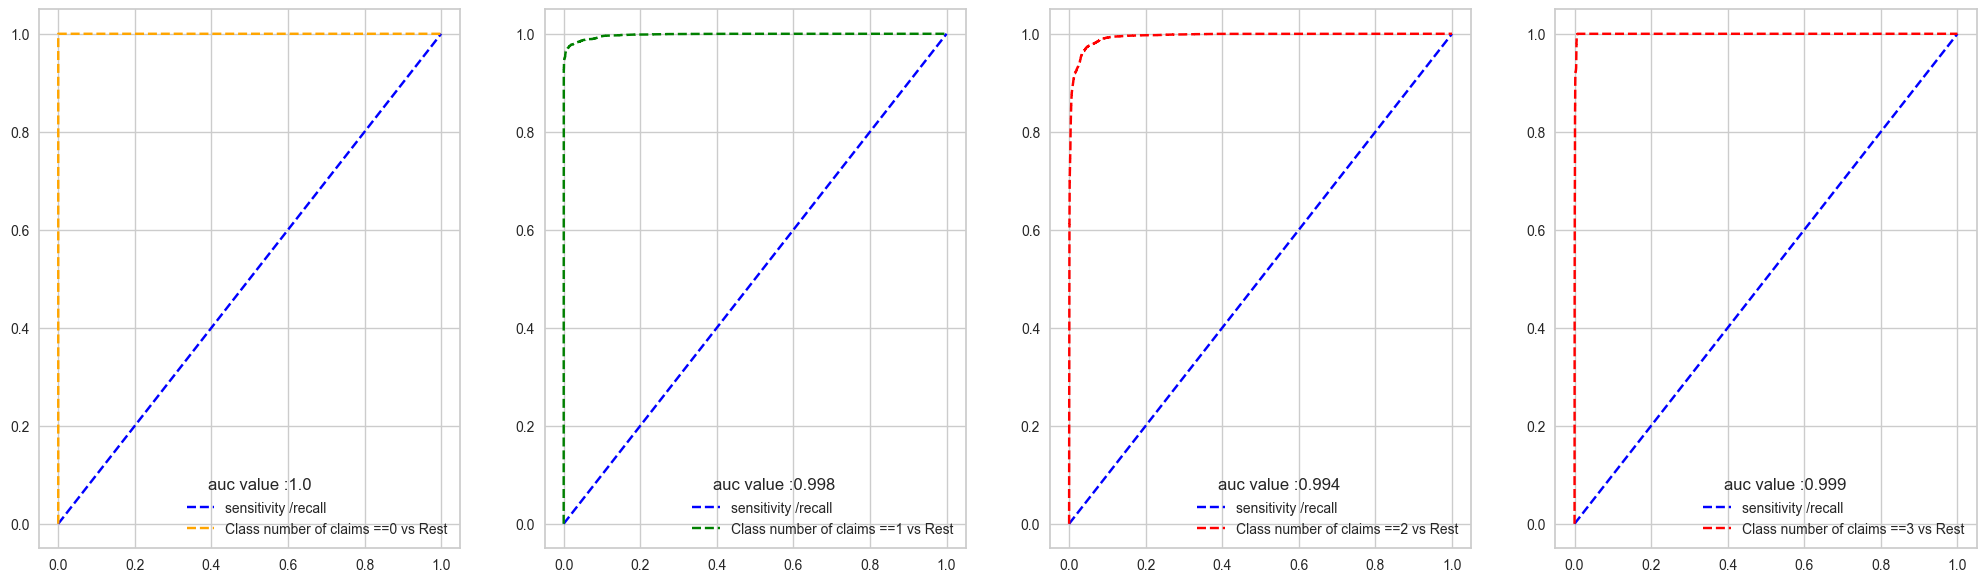

In [25]:
matplotlib.rcParams["figure.figsize"]=(25,7)
plt.subplot(141)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.39,0.07, f'auc value :{round(auc(fpr[0], tpr[0]),3)}')
plt.legend(['sensitivity /recall','Class number of claims ==0 vs Rest'])

plt.subplot(142)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.39,0.07, f'auc value :{round(auc(fpr[1], tpr[1]),3)}')
plt.legend(['sensitivity /recall','Class number of claims ==1 vs Rest'])

plt.subplot(143)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red')
plt.text(0.39,0.07, f'auc value :{round(auc(fpr[2], tpr[2]),3)}')
plt.legend(['sensitivity /recall','Class number of claims ==2 vs Rest'])

plt.subplot(144)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red')
plt.text(0.39,0.07, f'auc value :{round(auc(fpr[3], tpr[3]),3)}')
plt.legend(['sensitivity /recall','Class number of claims ==3 vs Rest'])


---

* *Features Importance*

In [26]:
importance=pd.concat([pd.DataFrame(XGBClassifier_model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(XGBClassifier_model.feature_importances_,columns=["feature_importances"])],axis=1)

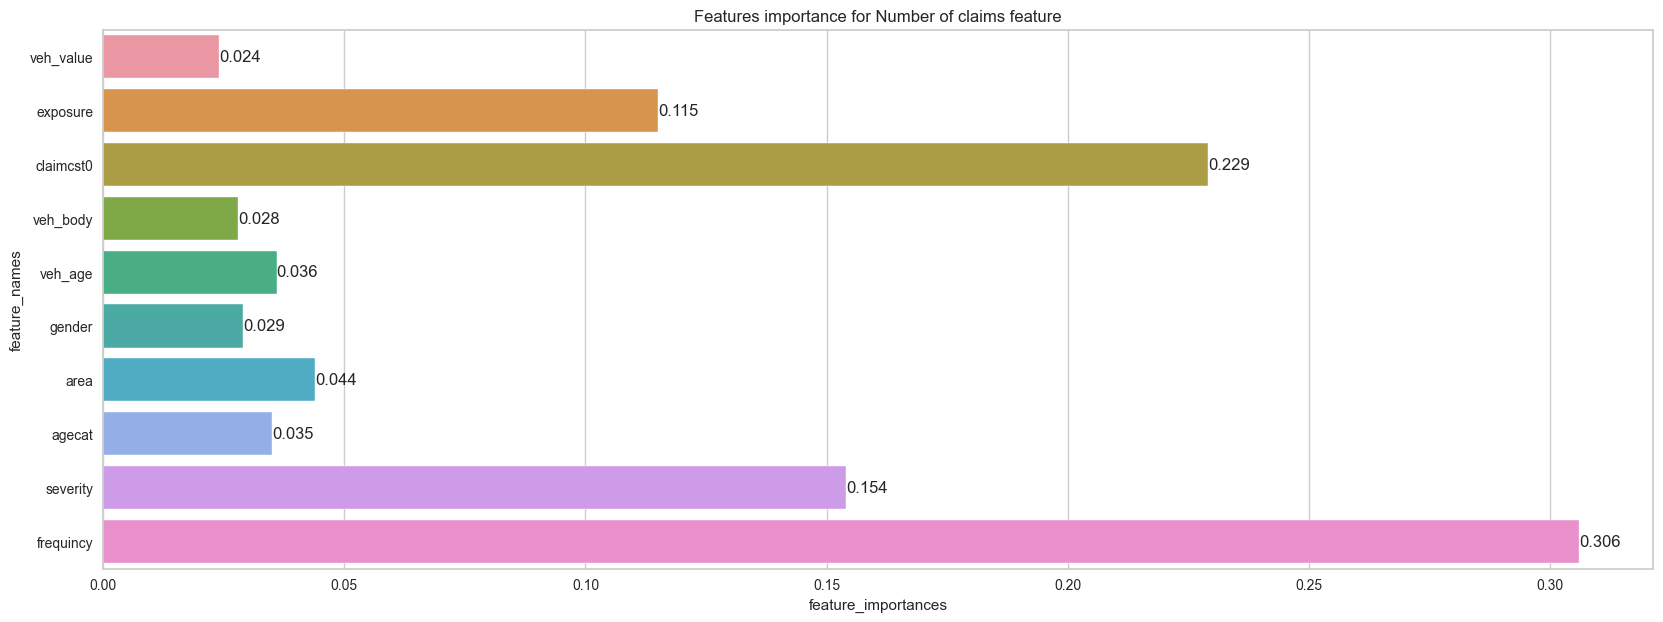

In [28]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Number of claims feature')
ax.bar_label(ax.containers[0]);

In [29]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/numclaims_prediction_model.pkl","wb") as f:
    pickle.dump(XGBClassifier_model,f)

---